## IBM Data Science Professional Certificate - Week 3
by Thiago Figueira

Today, we will explore and cluster the neighborhoods in **Toronto**. Since the data is not readily available in a neat dataframe, we have to collect it from the web and create our own. Luckily for us, Wikipedia has the data we need at: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In this notebook, we will

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 2>

1.  <a href="#item1">Acquire the Dataset</a>

2.  <a href="#item2">Acquire Neighborhood Coordinates</a>

3.  <a href="#item3">Analyze Each Neighborhood</a>

4.  <a href="#item4">Cluster Neighborhoods</a>

5.  <a href="#item5">Examine Clusters</a>  
    </font>
    </div>

## 1. Acquire the Dataset <a class="anchor" id="item1"></a>

In [15]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [16]:
# Download contents of the web page
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
data = requests.get(url).text

In [17]:
# Create BeautifulSoup object
soup = BeautifulSoup(data, 'html5lib')

In [18]:
# Get table
table = soup.find('table')

I understand that not all have contact with HTML or web development in general. For this reason, I created the chart below to demonstrate the essential structure of a HTML table:

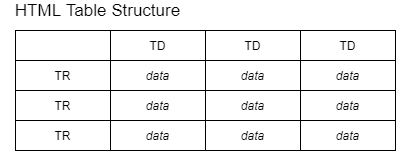

Observe that each *table row* (TD) has one or more *table data* (TD). However, our table has a different format: in each cell, the data is stacked.

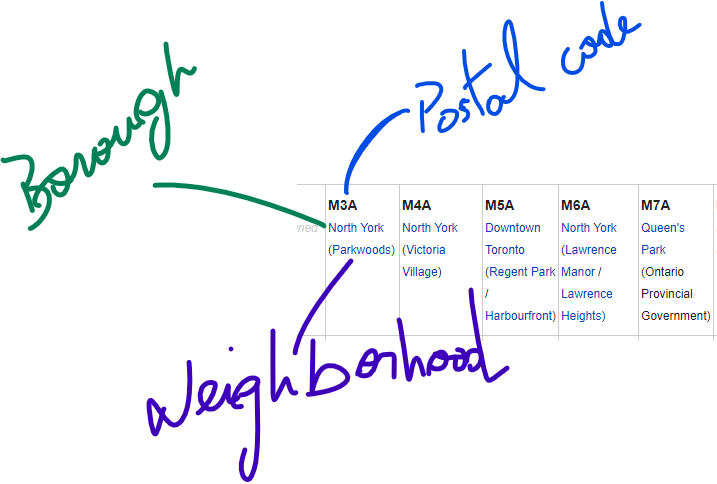


Hopefully this is help you understand the cell below

In [19]:
contents = []

# Get all rows
for row in table.find_all('td'):
    cell = {}
    if row.span.text == 'Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        contents.append(cell)

In [20]:
# Create dataframe
df = pd.DataFrame(contents)

# Change some values to more comprehensive names
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                     'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                     'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                     'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

# Visualize dataframe
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [21]:
print(df.shape)

(103, 3)


## 2. Acquire Neighborhood Coordinates <a class="anchor" id="item2"></a>

In [8]:
# Change the index of the dataframe to the PostalCode in a temporary df
temp_df = df.reset_index()
temp_df.drop(['index'], axis=1, inplace=True)
temp_df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [11]:
import geocoder

def get_coordinates(address):  
    '''
    
    This function uses the geocoder api to find the 
    longitude and latitude of the given address
    
    Returns a tuple containing the latitude and longitude, in this order 
    
    '''
    
    lat_long_coordinates = None
    print(address)

    # Loop due to the unreliability of the api
    while (lat_long_coordinates is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(address))
        print(g)
        lat_long_coordinates = g.latlng
    
    return (lat_long_coordinates[0], lat_long_coordinates[1])

In [12]:
temp_df['coodinates'] = temp_df['PostalCode'].apply(get_coordinates)

M3A
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>


KeyboardInterrupt: 

The api did not respond after waiting for twenty minutes

In [25]:
df_coordinates = pd.read_csv('Geospatial_Coordinates.csv')
df_coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [27]:
df_coordinates.columns = ['PostalCode', 'Latitude', 'Longitude']
df_coordinates.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [28]:
df = df.merge(df_coordinates, on='PostalCode')

In [29]:
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
